In [1]:
import os
from importlib import reload

import matplotlib.pyplot as plt
import moviepy.editor as mpy
import numpy as np
from IPython.display import Image, Video, clear_output

from sign_language_translator.vision import transforms as T
from sign_language_translator.vision import visualization as vis

# reload(T)
clear_output()

# load some data

In [4]:
word = 'd-D'
# file reading
pose_multi_frame_landmarks = np.loadtxt(os.path.join('inputs', f'pose_{word}_person205_front.csv'), skiprows=1,delimiter=',')
hand_multi_frame_landmarks = np.loadtxt(os.path.join('inputs', f'hand_{word}_person205_front.csv'), skiprows=1,delimiter=',')

# fix error (mirror hands horizontally)
hand_multi_frame_landmarks[..., np.arange(42)*3] *= -1

# stacking
all_multi_frame_landmarks = np.concatenate([pose_multi_frame_landmarks,
                                            hand_multi_frame_landmarks], axis=-1)

idx = 37
pose = pose_multi_frame_landmarks[idx]
hand = hand_multi_frame_landmarks[idx]
all_ =  all_multi_frame_landmarks[idx]

n_frames= len(all_multi_frame_landmarks)

# Transforms

## `Zoom`

`static`

In [159]:
frame_no = 37
original_img  = vis.landmarks_to_npimage(all_multi_frame_landmarks[frame_no])
zoomed_img  = vis.landmarks_to_npimage(
    T.zoom_landmarks(all_multi_frame_landmarks, 1.5, 0.75, 1)[frame_no]
)

stacked_img = np.concatenate([original_img, zoomed_img], axis=1)
vis.np2pil(stacked_img).save(os.path.join('outputs', 'zoom_static.png'))

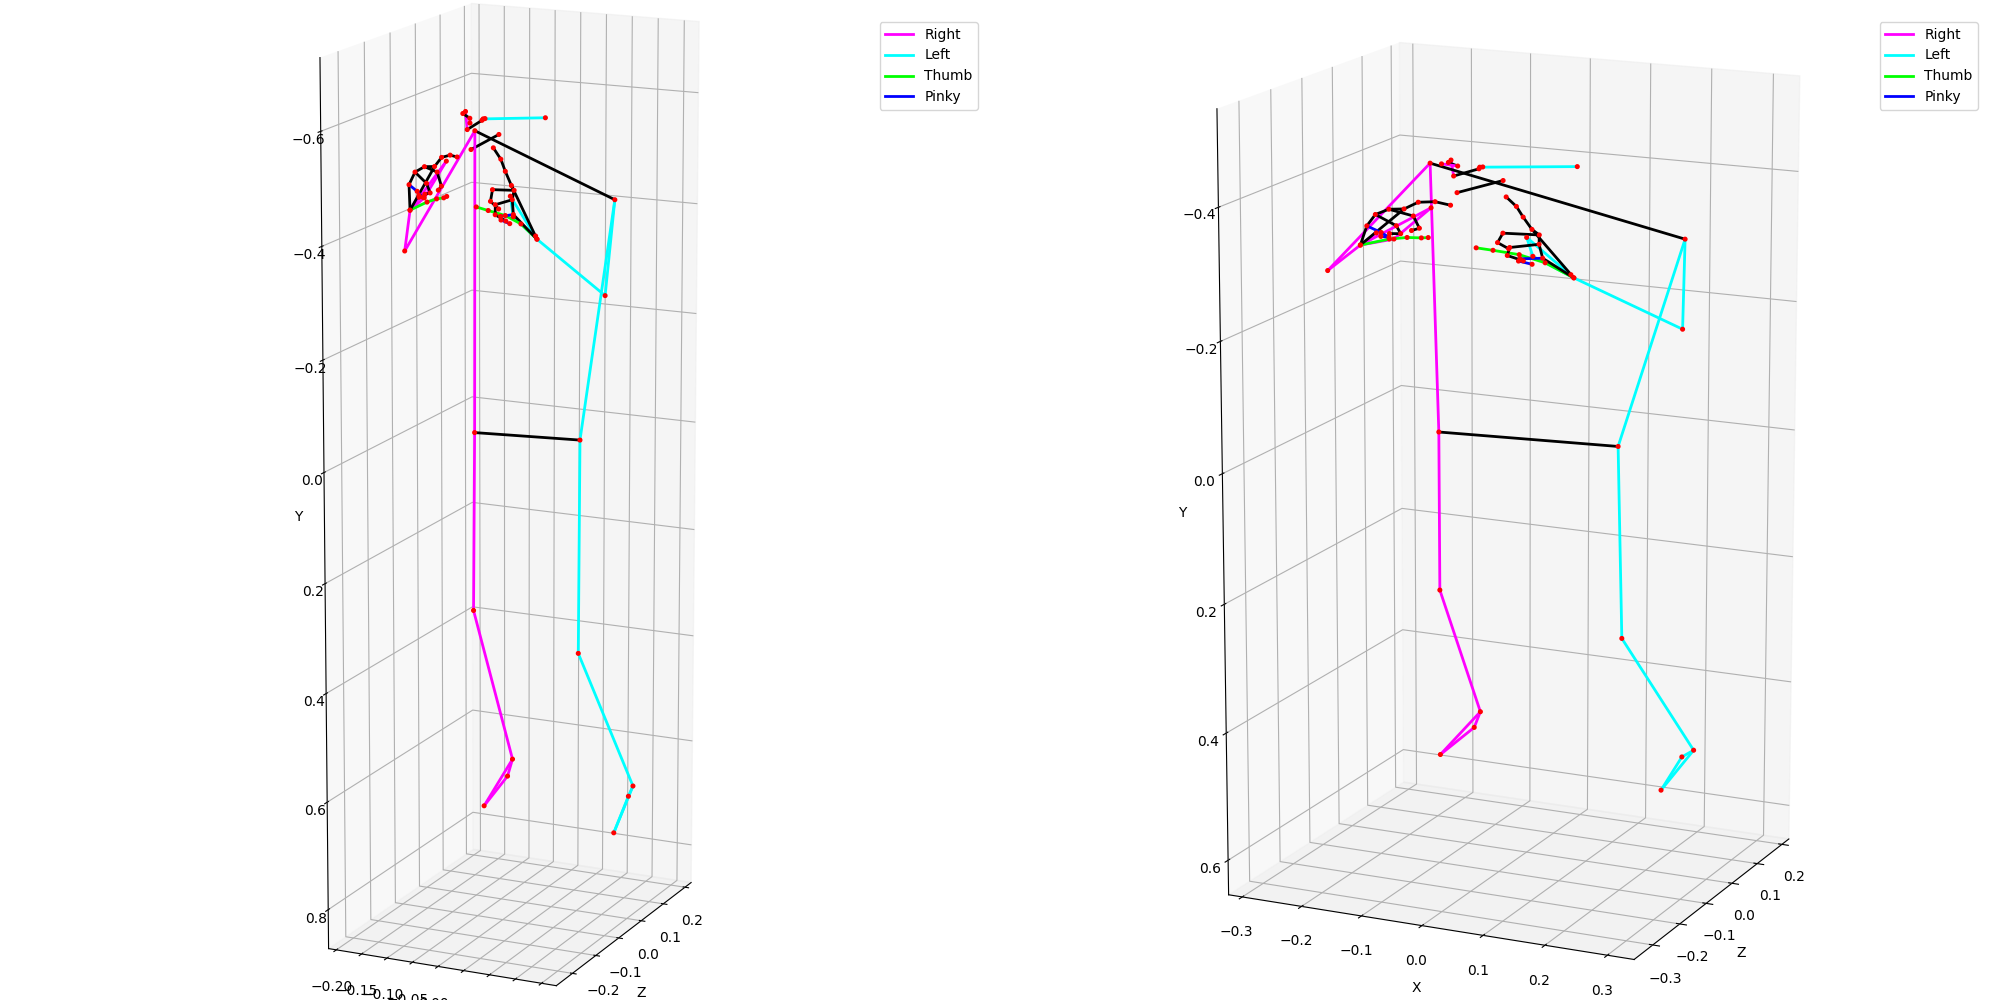

In [160]:
Image(os.path.join('outputs', 'zoom_static.png'))

`dynamic`

In [161]:
zoomed_img  = vis.multi_frame_landmarks_to_npimage(
    T.zoom_landmarks(
        all_multi_frame_landmarks[::15],
        x_factor = 1,
        y_factor = [0.75,1.25],
        z_factor = 1,
        add_random_steps=False, # un-smooth zooming
        add_slow_spots=False, # pauses zooming for a while on random spots
    )
)

vis.np2pil(zoomed_img[200:850]).save(os.path.join('outputs', 'zoom_dynamic.png'))

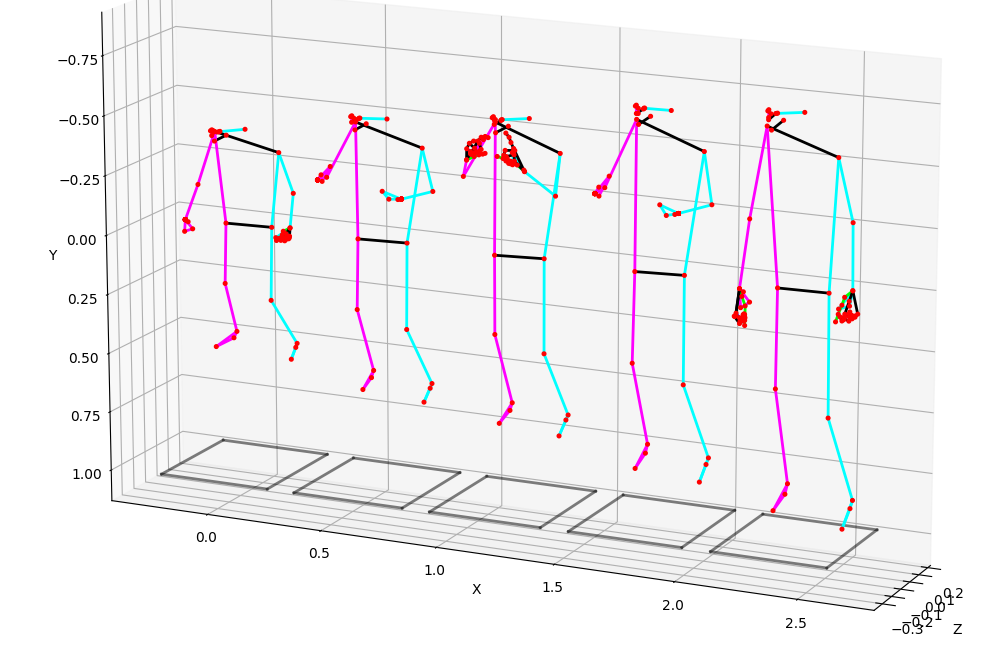

In [162]:
Image(os.path.join('outputs', 'zoom_dynamic.png'))

## `Rotate`

`static`

In [55]:
frame_no = 37
original_img  = vis.landmarks_to_npimage(all_multi_frame_landmarks[frame_no])
rotated_img  = vis.landmarks_to_npimage(
    T.rotate_landmarks(all_multi_frame_landmarks, 60, 30, -45, in_degrees=True)[frame_no]
)

stacked_img = np.concatenate([original_img, rotated_img], axis=1)
vis.np2pil(stacked_img).save(os.path.join('outputs', 'rotate_static.png'))

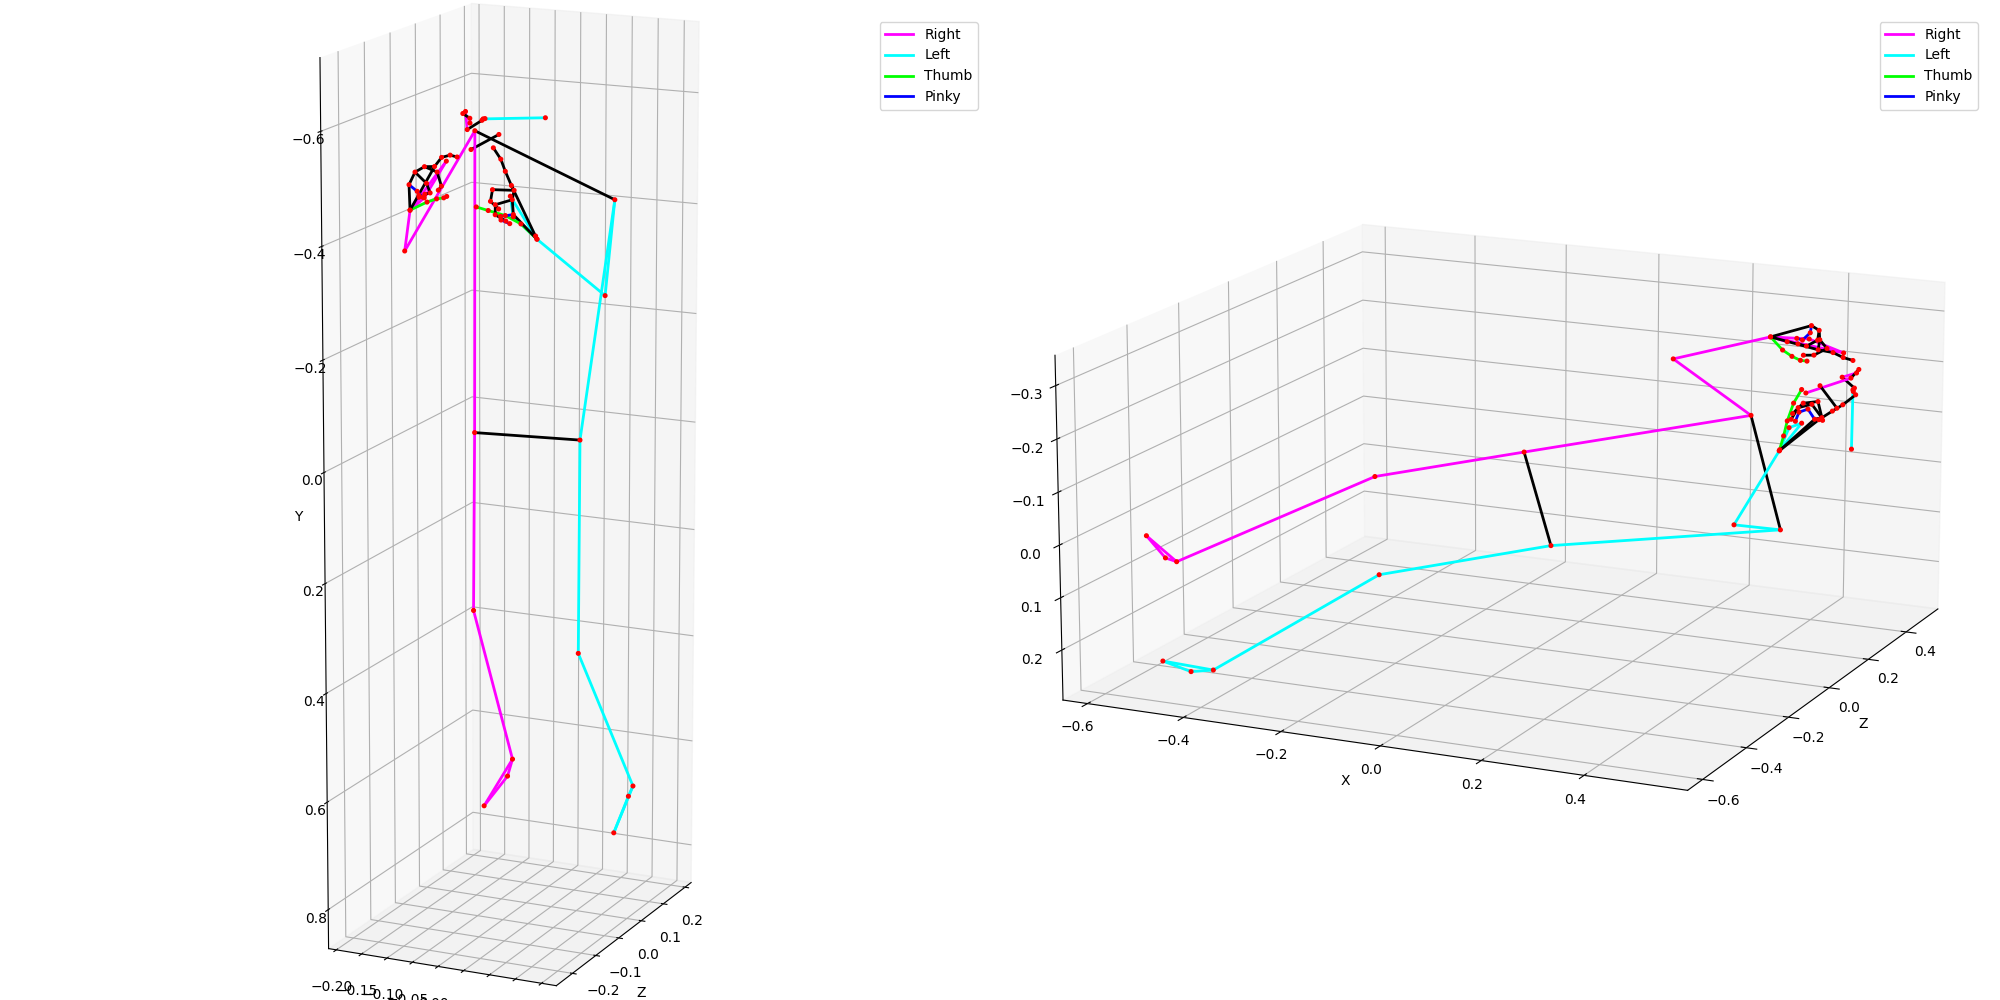

In [56]:
Image(os.path.join('outputs', 'rotate_static.png'))

`dynamic`

In [75]:
rotated_img  = vis.multi_frame_landmarks_to_npimage(
    T.rotate_landmarks(
        all_multi_frame_landmarks[::15],
        x_angle = [-1, 1],
        y_angle = 0,
        z_angle = 0,
        in_degrees=False, # = Radians
        add_random_steps=False, # un-smooth rotation
        add_slow_spots=False, # pauses rotation for a while on random spots
    )
)

vis.np2pil(rotated_img[200:800]).save(os.path.join('outputs', 'rotate_dynamic.png'))

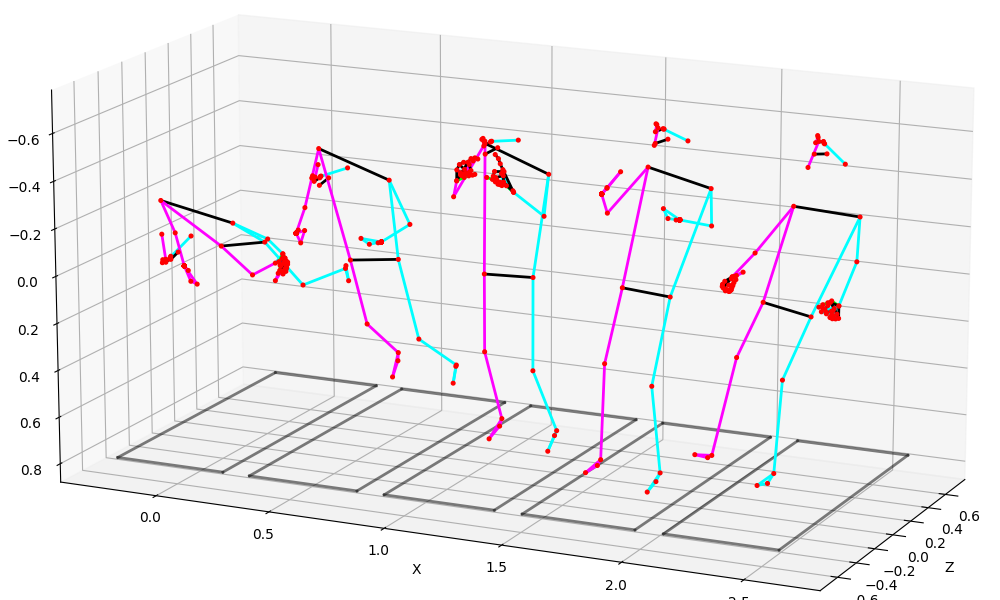

In [76]:
Image(os.path.join('outputs', 'rotate_dynamic.png'))

## `Noise`

`static`

In [ ]:
frame_no = 37
original_img  = vis.landmarks_to_npimage(all_multi_frame_landmarks[frame_no])
noisy_img  = vis.landmarks_to_npimage(
    T.noisy_landmarks(
        all_multi_frame_landmarks,
        through_time=False, # <-- this
        nlandmarks_mean_std=[
            [11, 0.003, 0.0005], # face
            [ 4, 0.020, 0.0050], # shoulders & elbows
            [ 8, 0.002, 0.0004], # pose hands
            [10, 0.020, 0.0050], # hips & legs
            [42, 0.002, 0.0004], # hands
        ]
    )[frame_no]
)

stacked_img = np.concatenate([original_img, noisy_img], axis=1)
vis.np2pil(stacked_img).save(os.path.join('outputs', 'noise_static.png'))

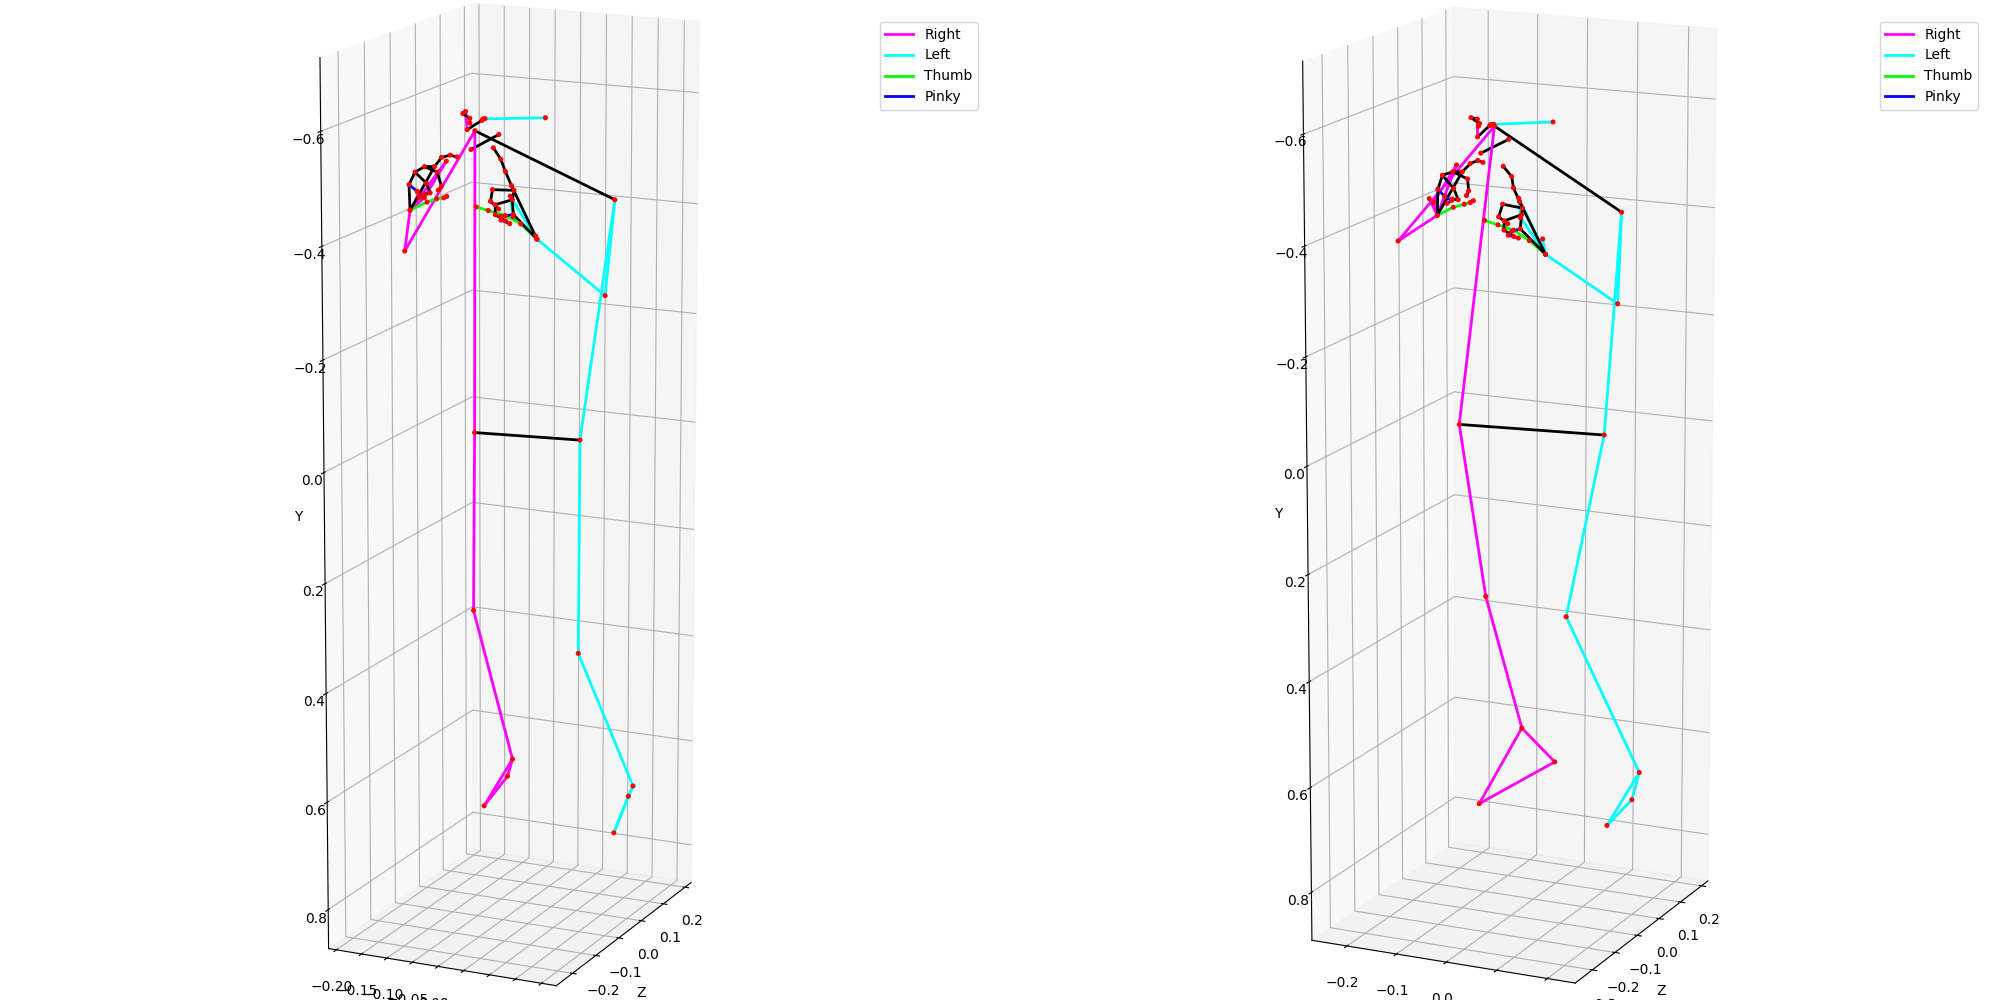

In [126]:
Image(os.path.join('outputs', 'noise_static.png'))

`dynamic`

In [157]:
noisy_landmarks  =  T.noisy_landmarks(
    all_multi_frame_landmarks,
    through_time = True, # <-- this
    nlandmarks_mean_std=[
        [11, 0.004, 0.0005], # face
        [ 4, 0.020, 0.0050], # shoulders & elbows
        [ 2, 0.008, 0.0009], # pose wrists
        [ 6, 0.002, 0.0004], # pose hands
        [10, 0.020, 0.0050], # hips & legs
        [42, 0.002, 0.0004], # hands
    ],
    visibility_noise_scale_mean=0.015,
    visibility_noise_scale_std =0.0025,
)

noisy_clip  = vis.multi_frame_landmarks_to_video(noisy_landmarks, elev=30, fig_height=6,fig_width=6)
noisy_clip.write_videofile(os.path.join('outputs', 'noise_dynamic.mp4'), threads=8)
noisy_clip.close()
clear_output()

In [2]:
Video(os.path.join('outputs', 'noise_dynamic.mp4'), html_attributes='loop autoplay')

## `Time dialation`

`speed change`

In [128]:
fast_landmarks = T.change_duration(all_multi_frame_landmarks, factor = 0.66, time_dimention = 0)
print(f'{all_multi_frame_landmarks.shape = }\n')
print(f'{fast_landmarks.shape            = }')

all_multi_frame_landmarks.shape = (67, 258)

fast_landmarks.shape            = (44, 258)


`Slow spots & Jitter`

In [94]:
slow_landmarks = [
    T.change_duration(
        all_multi_frame_landmarks,
        factor = 1.33,
        time_dimention = 0,
        use_random_speed=False,
        add_random_steps=use_rand_steps,
        add_slow_spots=use_slow_spots,
        # n_slow_spots_frac=0.04,
        slow_spots_steps_frac=0.25,

        return_new_timesteps=True
    )
    for use_rand_steps, use_slow_spots in [(False, False), (False, True), (True, True)]
]
clips = [
    vis.multi_frame_landmarks_to_video(landmarks, fig_height=8,fig_width=4)
    for landmarks, _ in slow_landmarks
]

stacked_clip = mpy.clips_array([clips])
try: stacked_clip.write_videofile(os.path.join('outputs', 'time_dialation.mp4'), threads=8)
except IndexError: pass
[clip.close() for clip in clips+[stacked_clip]]
clear_output()

In [95]:
# notice hands are raised and lowered out of sync
Video(os.path.join('outputs', 'time_dialation.mp4'), html_attributes='loop autoplay')

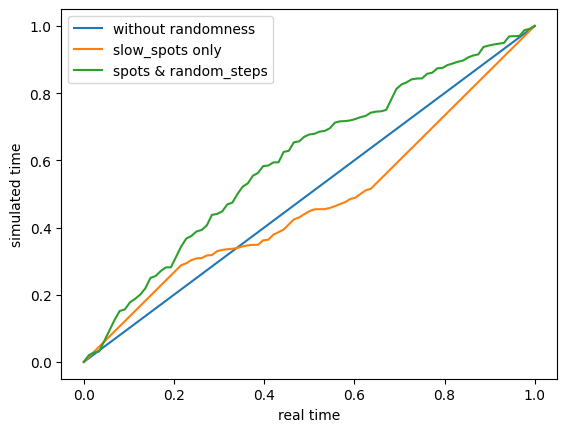

In [264]:
for (_, timesteps), label in zip(slow_landmarks, ['without randomness', 'slow_spots only', 'spots & random_steps']):
    plt.plot(np.linspace(0,1,len(timesteps)), timesteps, label=label)
plt.xlabel('real time')
plt.ylabel('simulated time')
plt.legend()
plt.show()

## `Stabilize / Rectify`

`stabilize`

In [ ]:
frame_no=37
rotated_landmarks_list = [
    T.rotate_landmarks(
        all_multi_frame_landmarks,
        *(np.random.rand(3)-0.5)*180,
        in_degrees=True,
    )
    for _ in range(5)
]
rotated_landmarks_screenshots = np.stack([
    landmarks[frame_no]
    for landmarks in rotated_landmarks_list
],axis=0)

stabilized_landmarks_list = T.stabilize_landmarks(
    rotated_landmarks_list,
    landmarks_to_use=[11,12,23,24], # shoulder and hips
    coordinates_to_use=[0,1,2], # x, y, z
    transformation_type='similarity', # use translation, scaling, rotation only
    infer_target=True, # the average torso in all clips
)
stabilized_landmarks_screenshots = np.stack([
    landmarks[frame_no]
    for landmarks in stabilized_landmarks_list
],axis=0)

img_r = vis.multi_frame_landmarks_to_npimage(rotated_landmarks_screenshots)[300:700]
img_s = vis.multi_frame_landmarks_to_npimage(stabilized_landmarks_screenshots)[300:700]

img_r_s = np.concatenate([img_r,img_s],axis=0)

vis.np2pil(img_r_s).save(os.path.join('outputs', 'stabilized.png'))

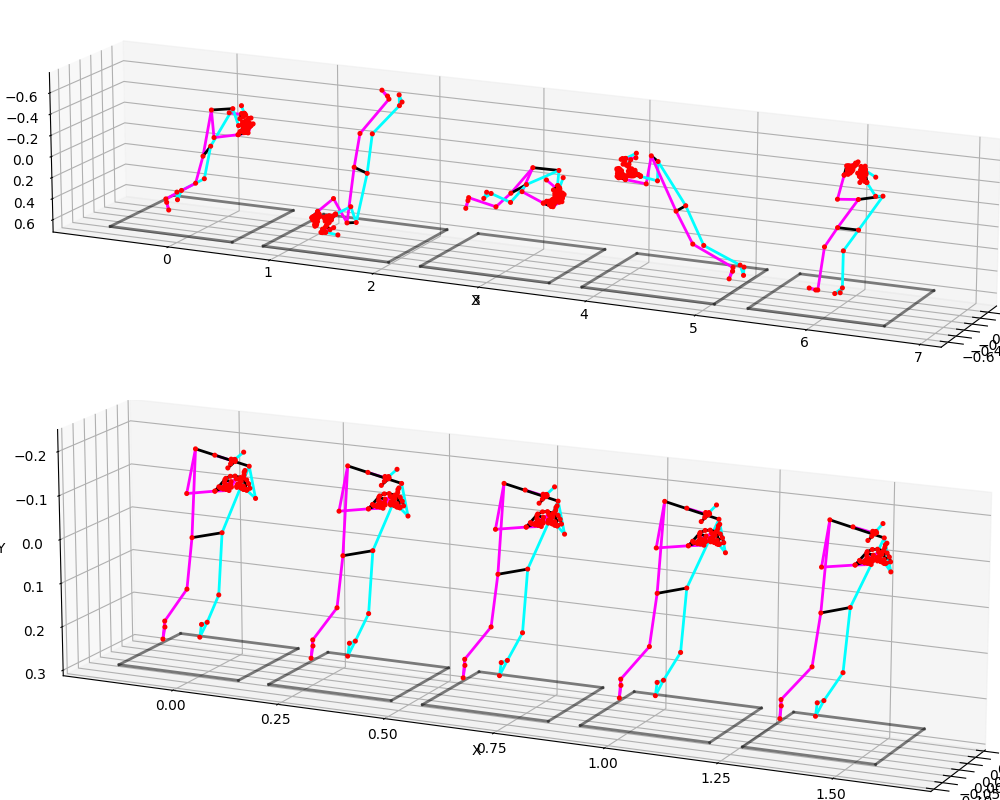

In [30]:
Image(os.path.join('outputs', 'stabilized.png'))

`rectify`

In [38]:
rectified_landmarks_list = T.stabilize_landmarks(
    rotated_landmarks_list,
    transformation_type='similarity',
    target=[
        # x  ,  y  , z
        [0.16, -0.5, 0], # left shoulder (z=0 means no depth)
        [-0.16, -0.5, 0], # right shoulder
        [0.10, 0, 0], # left hip
        [-0.10, 0, 0], # right hip
    ],
    infer_target=False,
)
rectified_landmarks_screenshots = np.stack([
    landmarks[frame_no]
    for landmarks in rectified_landmarks_list
],axis=0)

img_r = vis.multi_frame_landmarks_to_npimage(rotated_landmarks_screenshots)[300:650]
img_s = vis.multi_frame_landmarks_to_npimage(rectified_landmarks_screenshots)[180:840]

img_r_s = np.concatenate([img_r,img_s],axis=0)

vis.np2pil(img_r_s).save(os.path.join('outputs', 'rectified.png'))

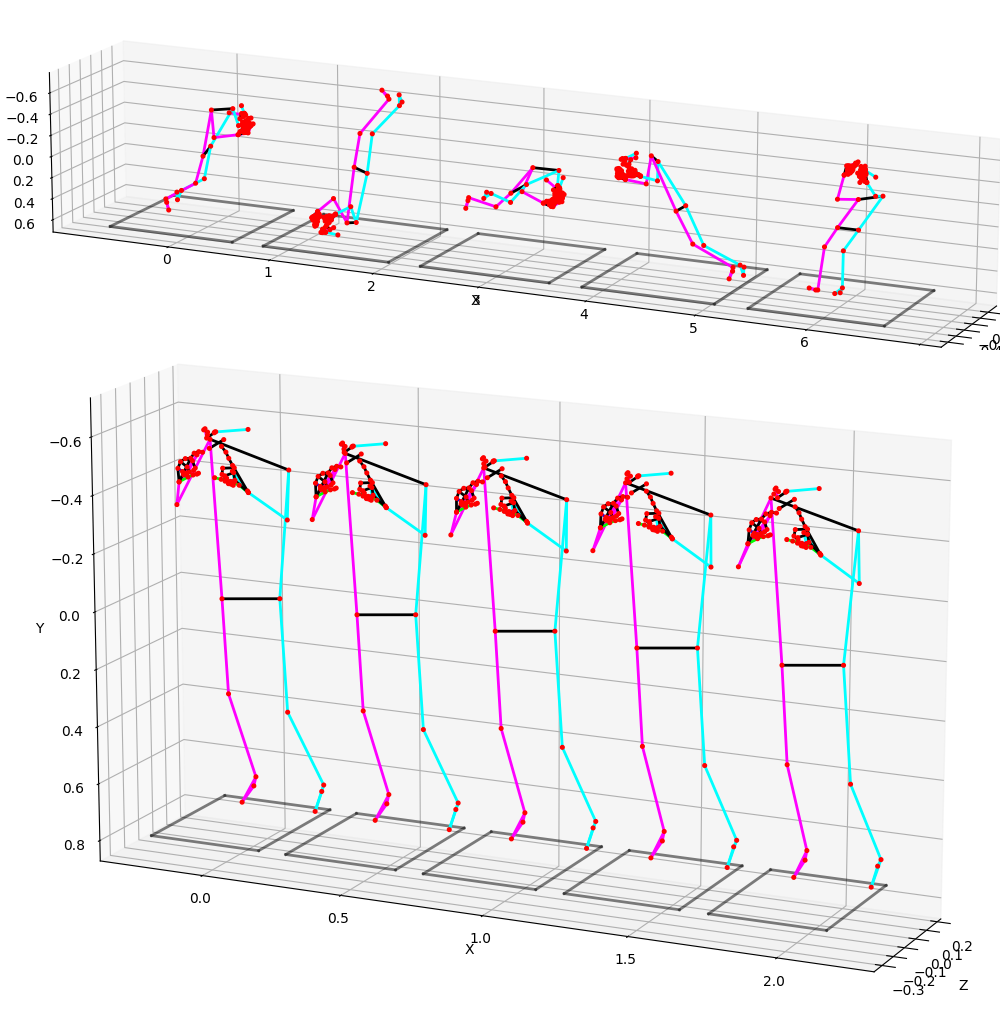

In [39]:
Image(os.path.join('outputs', 'rectified.png'))

`stabilize videos`

In [ ]:
clip = mpy.VideoFileClip('inputs/d-D_person205_front.mp4')
stabilized_clips = T.stabilize_clips(
    [clip, clip],
    [pose_multi_frame_landmarks, pose_multi_frame_landmarks], # use 2D Image landmarks for the best results
    landmarks_to_use=[11,12,23,24], # torso
    coordinates_to_use=[0,1], # x, y
    transformation_type='similarity', # shift, scale, rotate
    infer_target=True, # maps to the average position taken by the landmarks
    scale_landmarks=True, # first scale the landmarks by the dimention of the clip then estimate the transformation required.
)
# save or display moviepy video clips...
clip.close()
[c.close() for c in stabilized_clips]